In [1]:
import sys
sys.path.append('../')

from model import *
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pickle as pkl
import matplotlib.pyplot as plt

from utils_synthetic import *

In [2]:
import sklearn
sklearn.__version__

'1.0.2'

# Load child welfare synthetic data

This notebook runs the analysis on the childwelfare data by leveraging experts' agreement
1. Explore a model build on data ignoring experts 
2. Compute agreement between experts using influence function
3. Retrain the model on the set of labels for which experts strongly agree

The current analysis uses multi layer perceptrons in a single train / test split.

### Data

Reopen the data created with the notebook in `data/`

In [3]:
data_file = '../../../data/semi_synthetic/Data_semisynthetic_v1.pkl'

In [4]:
with open(data_file, 'rb') as handle:
    X,Y_1,Y_2,Y,D_0,refer_ids,screener_ids,coef_pred_y = pkl.load(handle)

In [5]:
#drop instances if expert assessed a single case

drop_experts = []
for num in screener_ids:

    if screener_ids.count(num) < 10:

        drop_experts.append(num)

In [6]:
drop_idx = []
for index, elem in enumerate(screener_ids):
    if elem in drop_experts:
        drop_idx.append(index)

In [7]:
X = np.delete(X,drop_idx,axis=0)
Y_1 = np.delete(Y_1,drop_idx,axis=0)
Y_2 = np.delete(Y_2,drop_idx,axis=0)
Y = np.delete(Y,drop_idx,axis=0)
D_0 = np.delete(D_0,drop_idx,axis=0)
refer_ids = np.delete(refer_ids,drop_idx,axis=0)
screener_ids = np.delete(screener_ids,drop_idx,axis=0)

In [8]:
selective_labels = True
#noise = True
opb = True
opb_blind = False

unobservables = False
unobs_k = 5 #number of unobsevables, k features with largest coefficient

change_some_coef = False #resample some coefficients for each human?
change_same = False
n=44#how many coefficients to change if change_some_coef == True
shared_bias = False
bias_opposite = False #if shared_bias true, should the bias overestimate the importance of use it in the opposite direction?

bias_assignment = False
change_all_coef = False#resample all non-zero coefficients?

random_if_not_good = False

#If opb_out, modeled as a business rule?
business_rule = False

#selective labels? Do we only observe label when D=1?


#HUMAN DECISIONS MODEL PARAMETERS

rand = False #are decisions made by humans random?

In [9]:
if not opb:
        Y = Y_1
elif opb_blind and not business_rule:
    Y = np.array([((Y_1[i]==1)&(D_0[i]==0)) for i in np.arange(len(Y_1))])
    Y_2 = 1-D_0
    logit = linear_model.LogisticRegression(penalty = 'l1', C=0.01, random_state=42, fit_intercept=False)
    clf = logit.fit(X, Y)
    Y_pred = clf.predict_proba(X)
    fpr, tpr,thres = sklearn.metrics.roc_curve(Y, Y_pred[:,1])
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    #print(roc_auc)
    coef_pred_y = clf.coef_
    #print(sum(coef_pred_y[0]!=0))
    #plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
elif opb_blind and business_rule:
    Y_2 = 1-D_0



if unobservables: #delete one of the variables that receive a lot of weight
    X_obs = np.delete(X,np.argsort(coef_pred_y[0])[-(unobs_k+2):-2],1)
else:
    X_obs = X

if bias_assignment:
    screener_ids = np.array(screener_ids)
    screener_ids[X[:,-2] == max(X[:,-2])] = 'TNew'
    screener_ids=list(screener_ids)

screener_set = np.array([x for x in set(screener_ids) if str(x)!='nan'])

D, alphas = decision_model(X, screener_ids, screener_set, coef_pred_y[0], change_coef = change_some_coef, change_same = change_same, change_all=change_all_coef, n=n,  shared_bias=shared_bias, rand= rand, bias_opposite=bias_opposite, bias_assignment= bias_assignment, random_if_not_good = random_if_not_good)

if opb and opb_blind and business_rule:
    D[D_0] = 0
    Y[D_0] = 0

#     with open('../../data/semi_synthetic/Y_human_'+setting+'.pkl', 'wb') as file:
#         pkl.dump([X,Y_1,Y_2,Y,D_0,refer_ids,screener_ids,coef_pred_y,D],file)
print(sum(D)/len(D))   
print(sum(D==Y)/len(D)   )

0.17584906671067793
-0.005476205209537613
1.0158579746721639
-0.13334347768524532
0.07014955719172215
0.3329449181487438
-0.4086493273803663
-0.3018175886512342
0.09250516286156582
-1.0031182711365132
-0.3784776049719885
0.19874481830162835
-0.5468587407138282
0.3529082087017505
0.5670509311808631
0.20859670722565707
-0.12610547111967024
0.08038419015972693
0.5047070964236448
0.010926227093504983
-0.3106767793084854
0.5577910711695088
-0.7715301614859382
-0.4529215392175088
-0.4464027245647797
0.11769069367302863
1.0788170849786094
-0.33291363606493224
-0.6309321965791945
-0.21311287432555168
-0.028117872789295086
0.49441764396169613
-1.5880920094736304
0.453017537826685
0.453017537826685
0.8816626547455296


In [10]:
Y_2 = Y_2*1

In [11]:
YC = [max(Y_1[i], Y_2[i]) for i in np.arange(len(Y_1))]

In [12]:
target = pd.DataFrame({'D': D, 'Y1': Y_1, 'Y2': Y_2, 'YC': YC})

In [58]:
print("D!=Y1: ",sum(target['D']!=target['Y1']))
print("Y2!=Y1: ",sum(target['Y2']!=target['Y1']))

D!=Y1:  7480
Y2!=Y1:  16276


In [14]:

#covariates, target, nurses = triage.drop(columns = ['D', 'Y1', 'Y2', 'YC', 'acuity', 'nurse']), triage[['D', 'Y1', 'Y2', 'YC']], triage['nurse']

In [15]:
# ids_map = {}
# screener_ids
# for i in range(len(set(screener_ids))):
#     ids_map[]

In [16]:
#convert screener ids to integers
#screener_ids = [int(i[2:]) for i in screener_ids]

Split data in a 80% train, 20% test

In [17]:
cov_train, cov_test, tar_train, tar_test, nur_train, nur_test = train_test_split(pd.DataFrame(X), target, pd.Series(screener_ids), test_size = 0.2, random_state = 42)

### Modelling

In [82]:
# Model's characteristics
params = {'layers': [200]} # If = [] equivalent to a simple logistic regression

# Amalgation parameters
rho = 0.05 # Control which point to consider from a confience point of view
pi_1 = 4.0 # Control criterion on centre mass metric
pi_2 = 0.8 # Control criterion on opposing metric
tau = 1.0  # Balance between observed and expert labels

##### 1. Train on decision

This model models the nurse decision based on covariates

In [83]:
for l1_penalty in [0.001, 0.01]:
    try:
        model = BinaryMLP(**params)
        model = model.fit(cov_train, tar_train['D'], nur_train, l1_penalty = l1_penalty)
        break
    except Exception as e:
        print(e, l1_penalty)
        pass

Loss: 0.267: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


In [84]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.9182113840308281

In [85]:
# Yc performance
roc_auc_score(tar_test['Y2'], model.predict(cov_test))

0.9087212860464831

In [86]:
roc_auc_score(tar_test['YC'], model.predict(cov_test))

0.9796188424449294

In [87]:
roc_auc_score(tar_test['D'], model.predict(cov_test))

0.9835947769108385

##### 2. Agreement computation 

Measure of agreeability are estimated in a cross validation fashion on the train set.

In [88]:
# Fold evaluation of influences
folds, predictions, influence = influence_cv(BinaryMLP, cov_train, tar_train['D'], nur_train, params = params)

Loss: 0.297: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


In [89]:
# Compute metrics agreeability
center_metric, opposing_metric = compute_agreeability(influence)

../model/amalgamation.py:78: RuntimeWarning: invalid value encountered in double_scalars
  center = np.dot(inf_sorted, np.arange(len(influence_point))) / np.sum(inf_sorted)
../model/amalgamation.py:86: RuntimeWarning: invalid value encountered in double_scalars
  opposing = np.max([inf_pos.sum(), - inf_neg.sum()]) / total


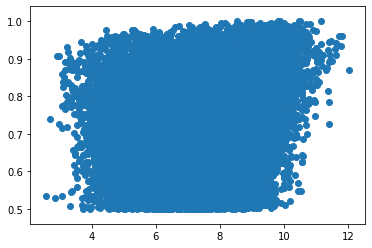

In [90]:
import matplotlib.pyplot as plt
plt.scatter(center_metric, opposing_metric)

In [91]:
# Apply criteria on amalgamation
high_conf = (predictions > (1 - rho)) | (predictions < rho)
high_agr = (center_metric > pi_1) & (opposing_metric > pi_2) & high_conf
high_agr_correct = ((predictions - tar_train['D']).abs() < rho) & high_agr

/zfsauton2/home/mdeartea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(array([17480.,  1255.,   737.,   545.,   500.,   510.,   571.,   690.,
         1201., 13733.]),
 array([0.01516332, 0.11192317, 0.20868302, 0.30544288, 0.40220273,
        0.49896258, 0.59572244, 0.69248229, 0.78924214, 0.88600199,
        0.98276185]),
 <a list of 10 Patch objects>)

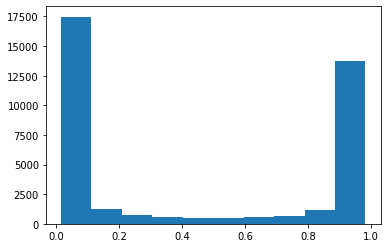

In [92]:
plt.hist(predictions)

In [93]:
print('high_conf:', sum(high_conf))
print('high_agr:', sum(high_agr))
print('high_agr_correct:', sum(high_agr_correct))

high_conf: 27089
high_agr: 6920
high_agr_correct: 6892


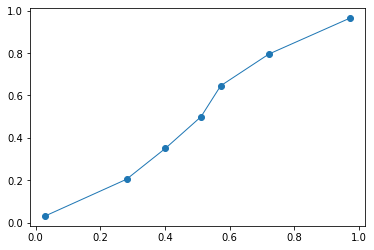

In [94]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(tar_train['D'], predictions, n_bins=7)
plt.plot(prob_true,prob_pred, marker='o', linewidth=1, label='logreg')


In [95]:
# Create amalgamated labels
tar_train['Ya'] = tar_train['Y1'].copy()
tar_train['Ya'][high_agr_correct] = (1 - tau) * tar_train['Y1'][high_agr_correct] \
                                    + tau * tar_train['D'][high_agr_correct]

/zfsauton2/home/mdeartea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [96]:
sum(tar_train['D']!=tar_train['Y1'])

5987

In [97]:
tar_train['Y1'][high_agr_correct]

437      0.0
15274    1.0
15291    0.0
26889    1.0
40083    0.0
        ... 
41090    0.0
16023    0.0
16850    1.0
44732    0.0
15795    1.0
Name: Y1, Length: 6892, dtype: float64

In [98]:
sum(tar_train['Ya']!=tar_train['Y1'])

534

In [99]:
#index for selective labels
index_amalg = [i==1.0 for i in tar_train['D']] | high_agr_correct

##### 3. Updated model

In [100]:
#model with selective labels
model = BinaryMLP(**params)
model = model.fit(cov_train[index_amalg], tar_train[index_amalg]['Ya'], nur_train[index_amalg])

Loss: 0.307: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


In [101]:
#model without selective labels
model = BinaryMLP(**params)
model = model.fit(cov_train, tar_train['Ya'], nur_train[index_amalg])

Loss: 0.267: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


In [102]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.9836494254164156

In [103]:
# Yc performance
roc_auc_score(tar_test['YC'],model.predict(cov_test))

0.9536716841064669

In [104]:
roc_auc_score(tar_test['Y2'],model.predict(cov_test))

0.7583237591707823

In [105]:
roc_auc_score(tar_test['D'],model.predict(cov_test))

0.9489329886806253

##### 4. Train on observed data

In [106]:
model = BinaryMLP(**params)
model = model.fit(cov_train, tar_train['Y1'], nur_train)

Loss: 0.252: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [107]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.9878009995329075

In [108]:
# Yc performance
roc_auc_score(tar_test['YC'],model.predict(cov_test))

0.9283404677969894

In [109]:
roc_auc_score(tar_test['Y2'],model.predict(cov_test))

0.7175254556204453

In [110]:
roc_auc_score(tar_test['D'],model.predict(cov_test))

0.9247488699783366